In [290]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('model_matchups_round1_classic_historical.csv')
print(df.shape)
df.head()

(477, 80)


,game_id,id,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,high_bracket_score,...,d_b,d_c,d_d,d_f,f_s,f_a,f_b,f_c,f_d,f_f
0,20081101,1101,2008,East,First Round,1,2008 North Carolina,16,2008 Mount St. Mary's,113,...,0,0,0,0,0,0,0,0,0,0
1,20081102,1102,2008,East,First Round,8,2008 Indiana,9,2008 Arkansas,72,...,0,0,0,0,0,0,0,0,0,0
2,20081103,1103,2008,East,First Round,5,2008 Notre Dame,12,2008 George Mason,68,...,0,0,0,0,0,0,0,0,0,0
3,20081104,1104,2008,East,First Round,4,2008 Washington St.,13,2008 Winthrop,71,...,0,0,0,0,0,0,0,0,0,0
4,20081105,1105,2008,East,First Round,6,2008 Oklahoma,11,2008 Saint Joseph's,72,...,0,0,0,0,0,0,0,0,0,0


In [291]:
df.columns.to_list()

['game_id',
 'id',
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'high_bracket_score',
 'low_bracket_score',
 'point_diff',
 'point_total',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f',
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f',
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f',
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']

In [292]:
df['win'].value_counts()

win
1    341
0    136
Name: count, dtype: int64

# I. Check Tiers

In [293]:
s_tiers = df[[
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f']]
print(s_tiers.value_counts())
a_tiers = df[[
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f']]
print(a_tiers.value_counts())
b_tiers = df[[
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f']]
print(b_tiers.value_counts())
c_tiers = df[[
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f']]
print(c_tiers.value_counts())
d_tiers = df[[
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f']]
print(d_tiers.value_counts())
f_tiers = df[[
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']]
print(f_tiers.value_counts())

s_s  s_a  s_b  s_c  s_d  s_f
0    0    0    0    0    0      377
                         1       83
                    1    0       13
               1    0    0        4
Name: count, dtype: int64
a_s  a_a  a_b  a_c  a_d  a_f
0    0    0    0    0    0      420
                         1       35
                    1    0       17
               1    0    0        5
Name: count, dtype: int64
b_s  b_a  b_b  b_c  b_d  b_f
0    0    0    0    0    0      385
               1    0    0       33
               0    1    0       30
                    0    1       27
          1    0    0    0        2
Name: count, dtype: int64
c_s  c_a  c_b  c_c  c_d  c_f
0    0    0    0    0    0      250
               1    0    0      167
               0    1    0       41
                    0    1       16
          1    0    0    0        3
Name: count, dtype: int64
d_s  d_a  d_b  d_c  d_d  d_f
0    0    0    0    0    0      476
               1    0    0        1
Name: count, dtype: int64
f_s  

In [294]:
# Remove all tier matchups that happened five or less times and view win percentage of the the remaining tiers
all_tiers = df[[
 'win',
 's_d',
 's_f',
 'a_d',
 'a_f',
 'b_c',
 'b_d',
 'b_f',
 'c_c',
 'c_d',
 'c_f']]

In [295]:
all_tiers.groupby(by=['win', 's_d']).size()

win  s_d
0    0      134
     1        2
1    0      330
     1       11
dtype: int64

In [296]:
all_tiers.groupby(by=['win', 's_f']).size()

win  s_f
0    0      135
     1        1
1    0      259
     1       82
dtype: int64

In [297]:
all_tiers.groupby(by=['win', 'a_d']).size()

win  a_d
0    0      133
     1        3
1    0      327
     1       14
dtype: int64

In [298]:
all_tiers.groupby(by=['win', 'a_f']).size()

win  a_f
0    0      135
     1        1
1    0      307
     1       34
dtype: int64

In [299]:
all_tiers.groupby(by=['win', 'b_c']).size()

win  b_c
0    0      125
     1       11
1    0      319
     1       22
dtype: int64

In [300]:
all_tiers.groupby(by=['win', 'b_d']).size()

win  b_d
0    0      128
     1        8
1    0      319
     1       22
dtype: int64

In [301]:
all_tiers.groupby(by=['win', 'b_f']).size()

win  b_f
0    0      128
     1        8
1    0      322
     1       19
dtype: int64

In [302]:
all_tiers.groupby(by=['win', 'c_c']).size()

win  c_c
0    0       58
     1       78
1    0      252
     1       89
dtype: int64

In [303]:
all_tiers.groupby(by=['win', 'c_d']).size()

win  c_d
0    0      121
     1       15
1    0      315
     1       26
dtype: int64

In [304]:
all_tiers.groupby(by=['win', 'c_f']).size()

win  c_f
0    0      132
     1        4
1    0      329
     1       12
dtype: int64

In [305]:
# Remove any tier with win percentages under 80% and keep only columns that can be included in a model
eda_df = df[[
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_d',
 's_f',
 'a_d',
 'a_f']]
eda_df.shape

(477, 35)

In [306]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((333, 34), (144, 34))

In [307]:
y_train.shape, y_test.shape

((333,), (144,))

In [308]:
X_train.head()

,ovr_rating_bpi,ovr_rating_kenpom,ovr_rating_torvik,wab,off_rating_bpi,off_rating_kenpom,off_rating_torvik,def_rating_bpi,def_rating_kenpom,def_rating_torvik,...,eff_def,ft%_def,height_eff,size,bench,adj_tempo,s_d,s_f,a_d,a_f
206,5.3000,6.0889,0.0546,2.5756,0.7000,9.5564,9.3851,4.7000,-2.8464,-5.0973,...,-12.2962,2.4000,3.1600,0.0100,14.2300,-0.2000,0,0,0,0
81,4.7000,5.7369,0.0625,2.7861,9.2000,4.5048,3.5292,-4.5000,1.0550,2.4815,...,-7.0335,2.6000,-5.4100,-1.4900,10.3600,3.2000,0,0,0,0
343,12.3000,19.5434,0.2880,11.5157,6.9000,20.7905,18.9828,5.3000,-1.1924,1.6838,...,-3.9140,5.7000,1.7500,1.6400,-7.3500,0.1000,0,0,0,0
365,1.3000,0.5990,-0.0199,3.4763,-0.1000,5.1802,3.4398,1.3000,-5.0412,-5.1096,...,-9.7620,-4.6000,1.1300,0.9200,-11.9100,6.1000,0,0,0,0
438,16.5000,21.8277,0.3373,12.7503,12.1000,22.3166,20.2708,4.3000,-0.2843,0.7372,...,-9.4862,0.3000,-1.1500,0.1900,-1.4700,-3.5000,0,0,0,1


In [309]:
X_train.columns.to_list()

['ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_d',
 's_f',
 'a_d',
 'a_f']

# II. Box Plots

<Axes: xlabel='win', ylabel='ovr_rating_bpi'>

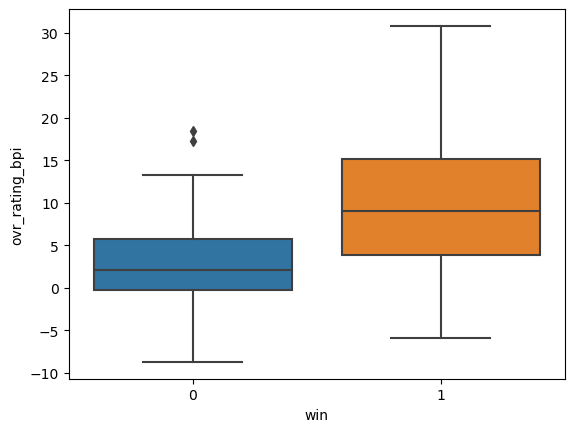

In [310]:
sns.boxplot(data=df, x='win', y='ovr_rating_bpi')

<Axes: xlabel='win', ylabel='ovr_rating_kenpom'>

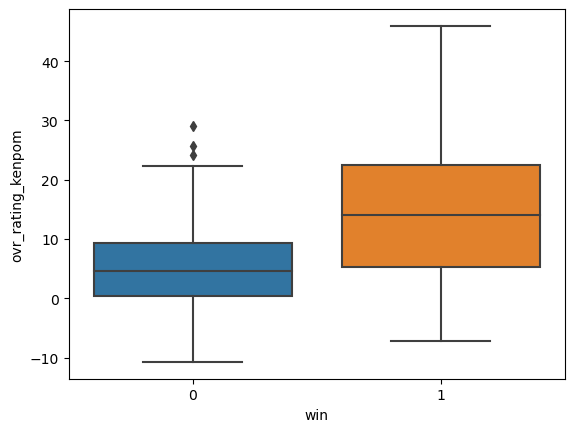

In [311]:
sns.boxplot(data=df, x='win', y='ovr_rating_kenpom')

<Axes: xlabel='win', ylabel='ovr_rating_torvik'>

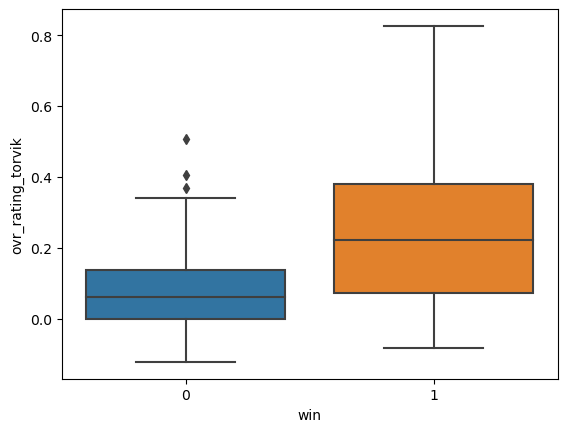

In [312]:
sns.boxplot(data=df, x='win', y='ovr_rating_torvik')

<Axes: xlabel='win', ylabel='wab'>

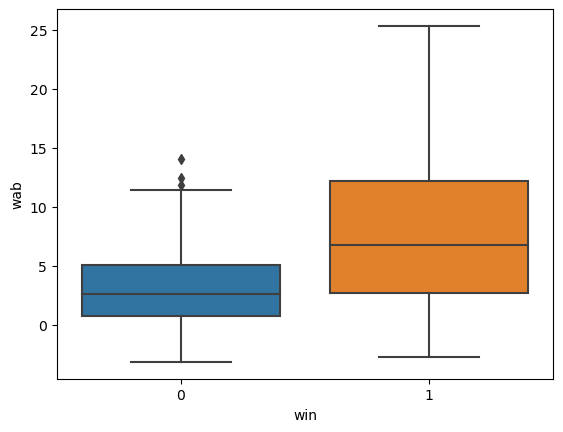

In [313]:
sns.boxplot(data=df, x='win', y='wab')

<Axes: xlabel='win', ylabel='off_rating_bpi'>

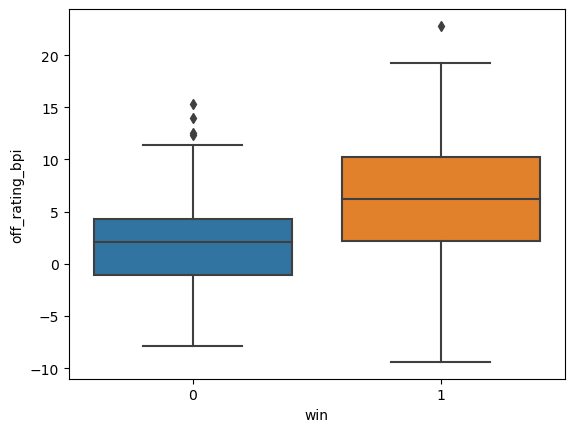

In [314]:
sns.boxplot(data=df, x='win', y='off_rating_bpi')

<Axes: xlabel='win', ylabel='off_rating_kenpom'>

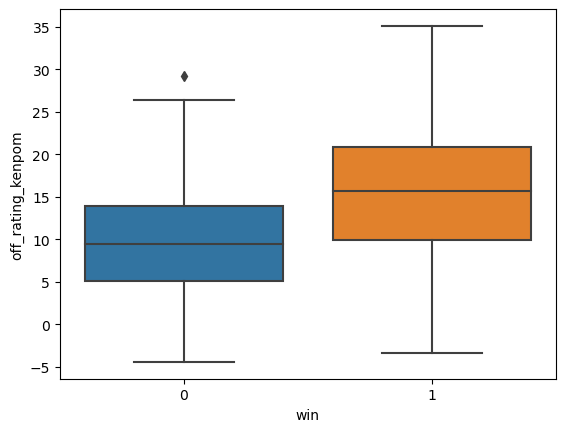

In [315]:
sns.boxplot(data=df, x='win', y='off_rating_kenpom')

<Axes: xlabel='win', ylabel='off_rating_torvik'>

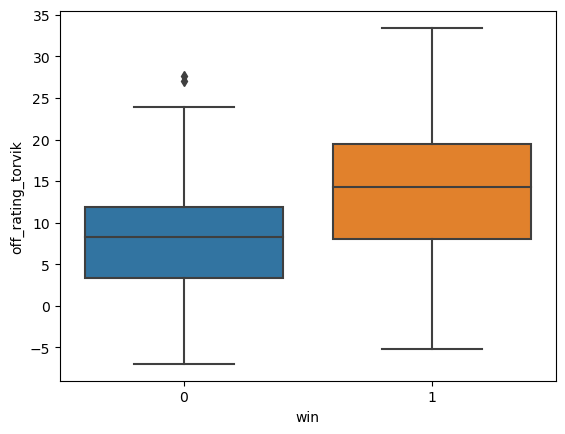

In [316]:
sns.boxplot(data=df, x='win', y='off_rating_torvik')

<Axes: xlabel='win', ylabel='def_rating_torvik'>

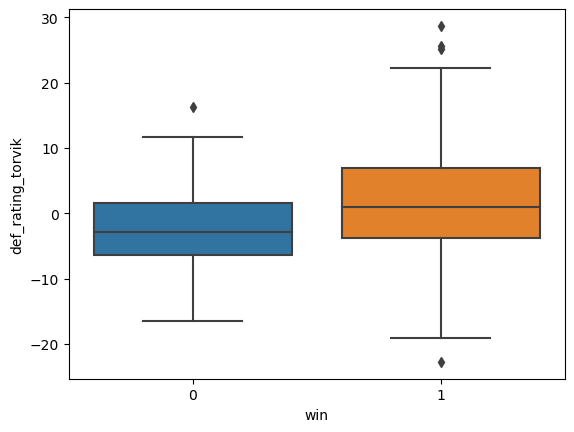

In [317]:
sns.boxplot(data=df, x='win', y='def_rating_torvik')

<Axes: xlabel='win', ylabel='efg%_off'>

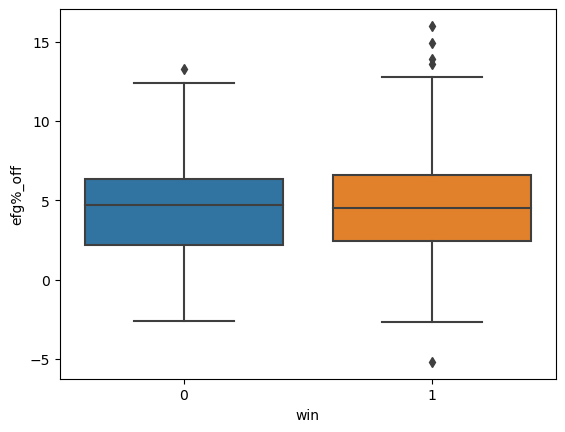

In [318]:
sns.boxplot(data=df, x='win', y='efg%_off')

<Axes: xlabel='win', ylabel='ftr_off'>

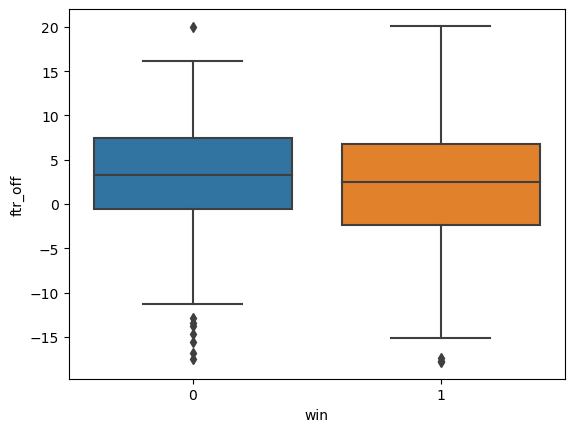

In [319]:
sns.boxplot(data=df, x='win', y='ftr_off')

<Axes: xlabel='win', ylabel='reb%_off'>

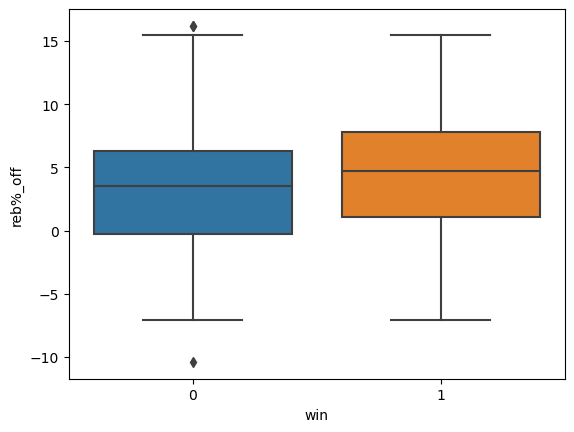

In [320]:
sns.boxplot(data=df, x='win', y='reb%_off')

<Axes: xlabel='win', ylabel='to%_off'>

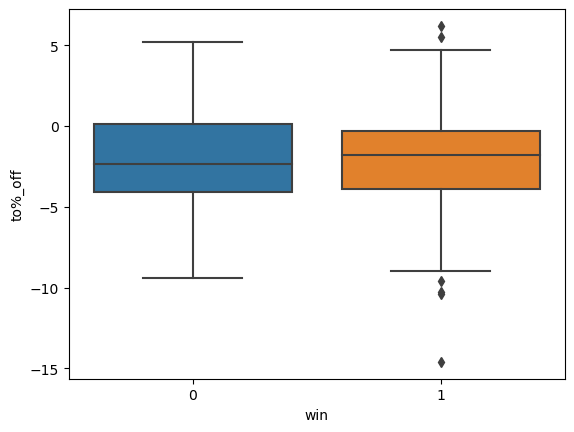

In [321]:
sns.boxplot(data=df, x='win', y='to%_off')

<Axes: xlabel='win', ylabel='efg%_def'>

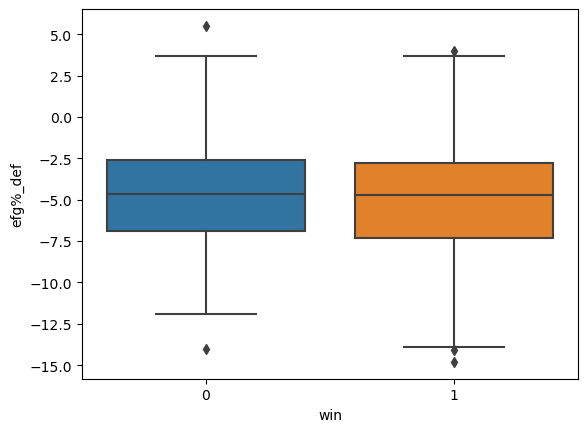

In [322]:
sns.boxplot(data=df, x='win', y='efg%_def')

<Axes: xlabel='win', ylabel='ftr_def'>

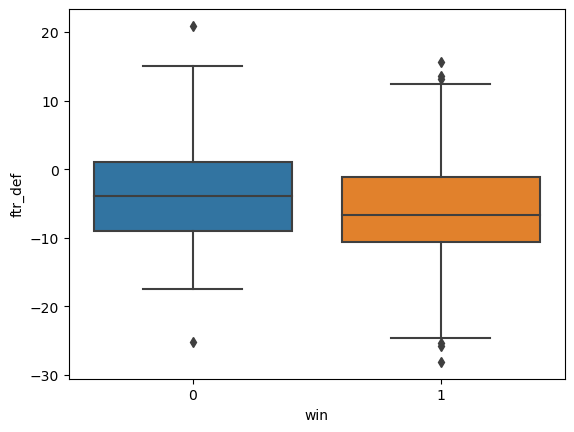

In [323]:
sns.boxplot(data=df, x='win', y='ftr_def')

<Axes: xlabel='win', ylabel='reb%_def'>

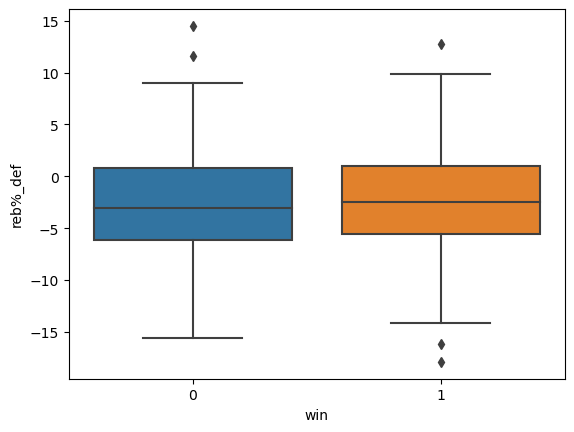

In [324]:
sns.boxplot(data=df, x='win', y='reb%_def')

<Axes: xlabel='win', ylabel='to%_def'>

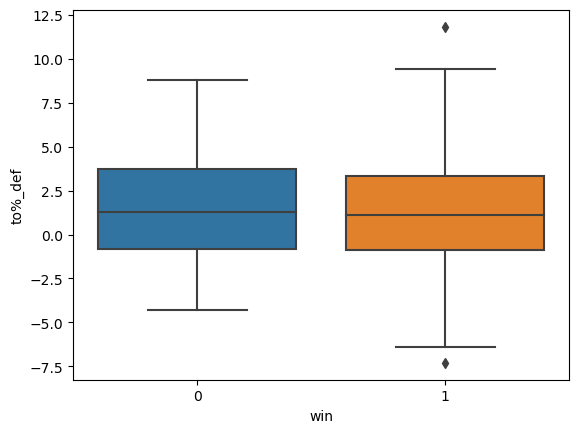

In [325]:
sns.boxplot(data=df, x='win', y='to%_def')

<Axes: xlabel='win', ylabel='2p%_off'>

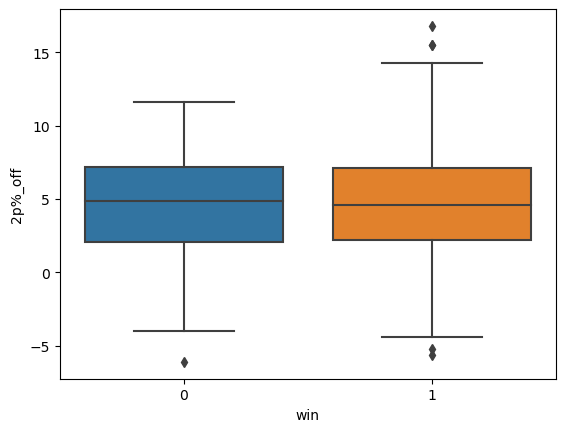

In [326]:
sns.boxplot(data=df, x='win', y='2p%_off')

<Axes: xlabel='win', ylabel='3p%_off'>

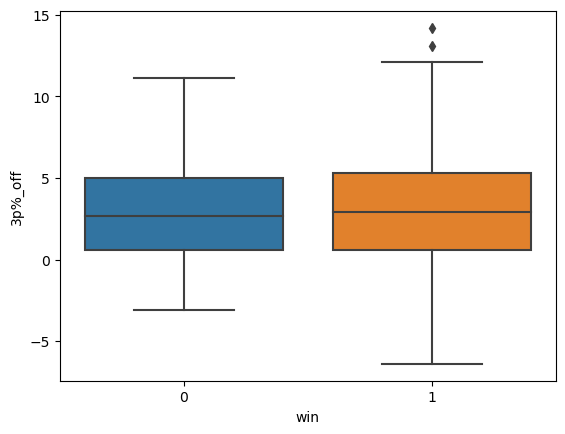

In [327]:
sns.boxplot(data=df, x='win', y='3p%_off')

<Axes: xlabel='win', ylabel='eff_off'>

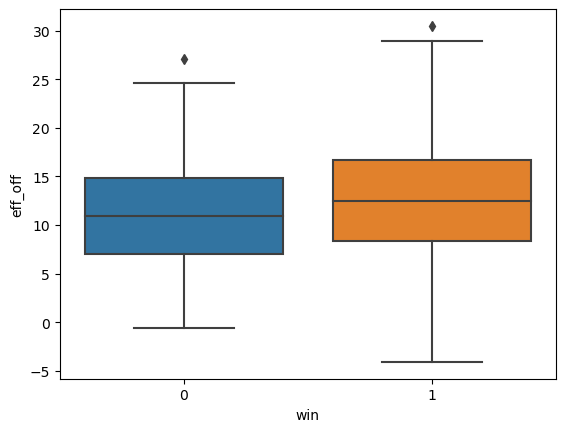

In [328]:
sns.boxplot(data=df, x='win', y='eff_off')

<Axes: xlabel='win', ylabel='ft%_off'>

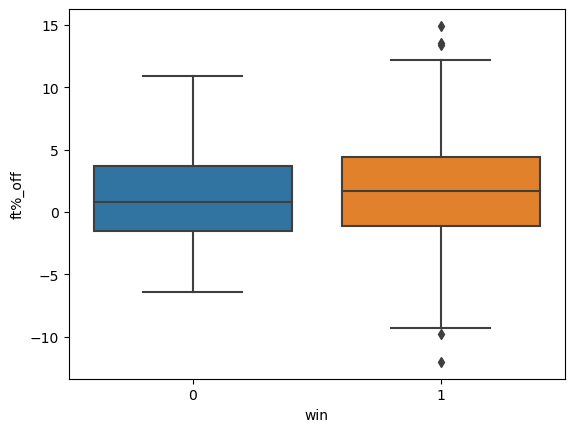

In [329]:
sns.boxplot(data=df, x='win', y='ft%_off')

<Axes: xlabel='win', ylabel='2p%_def'>

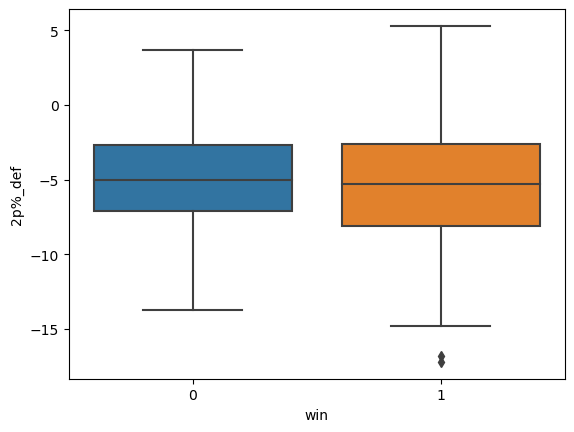

In [330]:
sns.boxplot(data=df, x='win', y='2p%_def')

<Axes: xlabel='win', ylabel='3p%_def'>

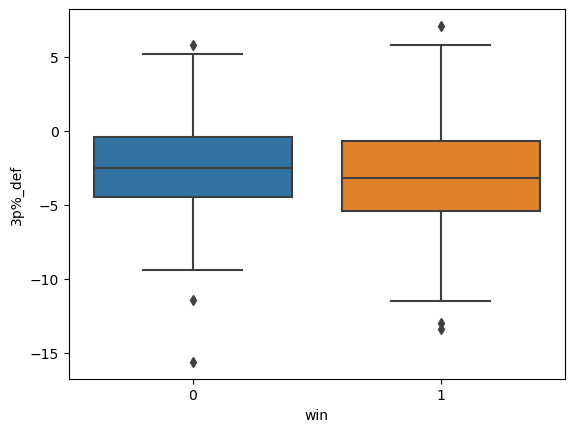

In [331]:
sns.boxplot(data=df, x='win', y='3p%_def')

<Axes: xlabel='win', ylabel='eff_def'>

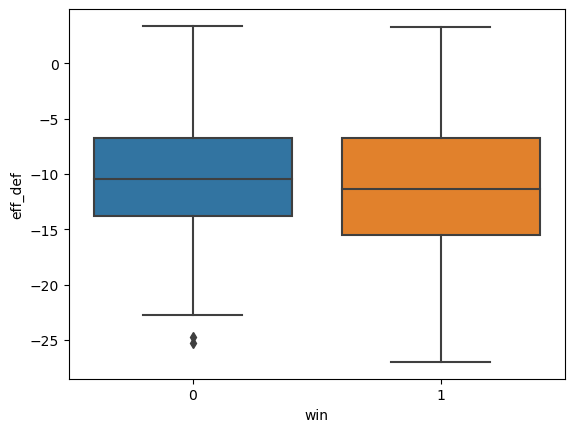

In [332]:
sns.boxplot(data=df, x='win', y='eff_def')

<Axes: xlabel='win', ylabel='ft%_def'>

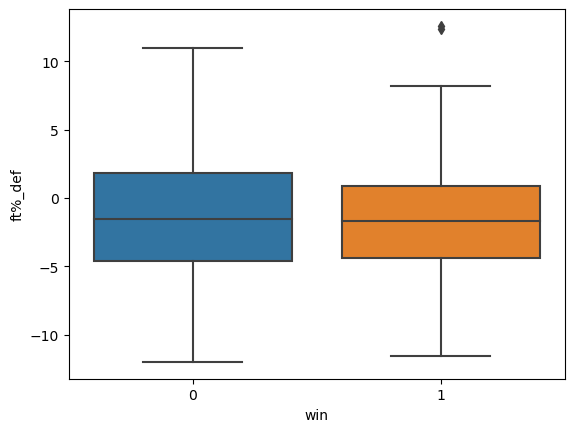

In [333]:
sns.boxplot(data=df, x='win', y='ft%_def')

<Axes: xlabel='win', ylabel='height_eff'>

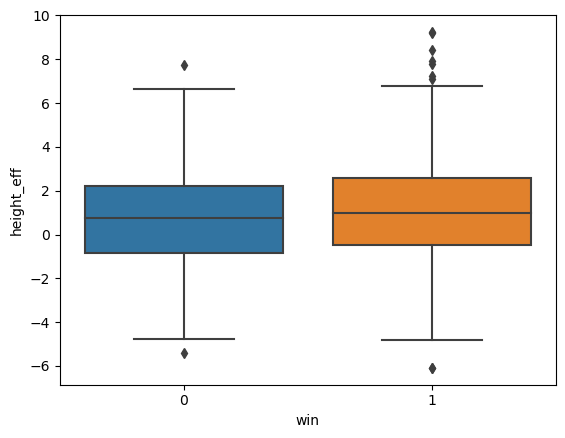

In [334]:
sns.boxplot(data=df, x='win', y='height_eff')

<Axes: xlabel='win', ylabel='size'>

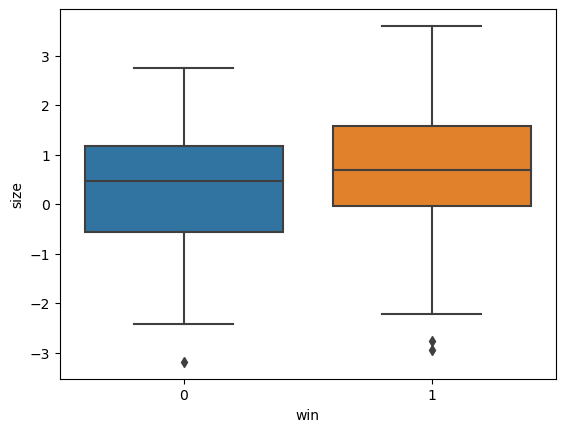

In [335]:
sns.boxplot(data=df, x='win', y='size')

<Axes: xlabel='win', ylabel='bench'>

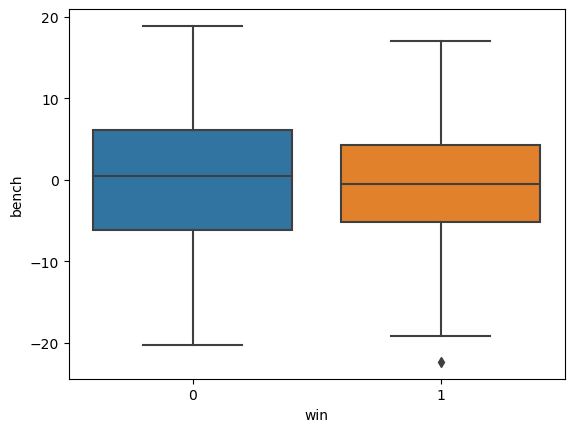

In [336]:
sns.boxplot(data=df, x='win', y='bench')

<Axes: xlabel='win', ylabel='adj_tempo'>

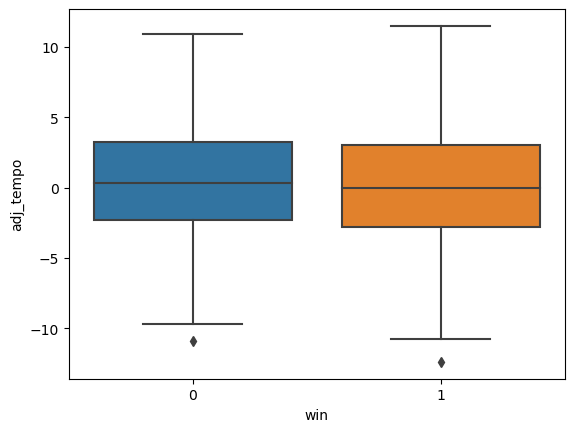

In [337]:
sns.boxplot(data=df, x='win', y='adj_tempo')

# III. Mutual Information

Text(0, 0.5, 'Mutual Information')

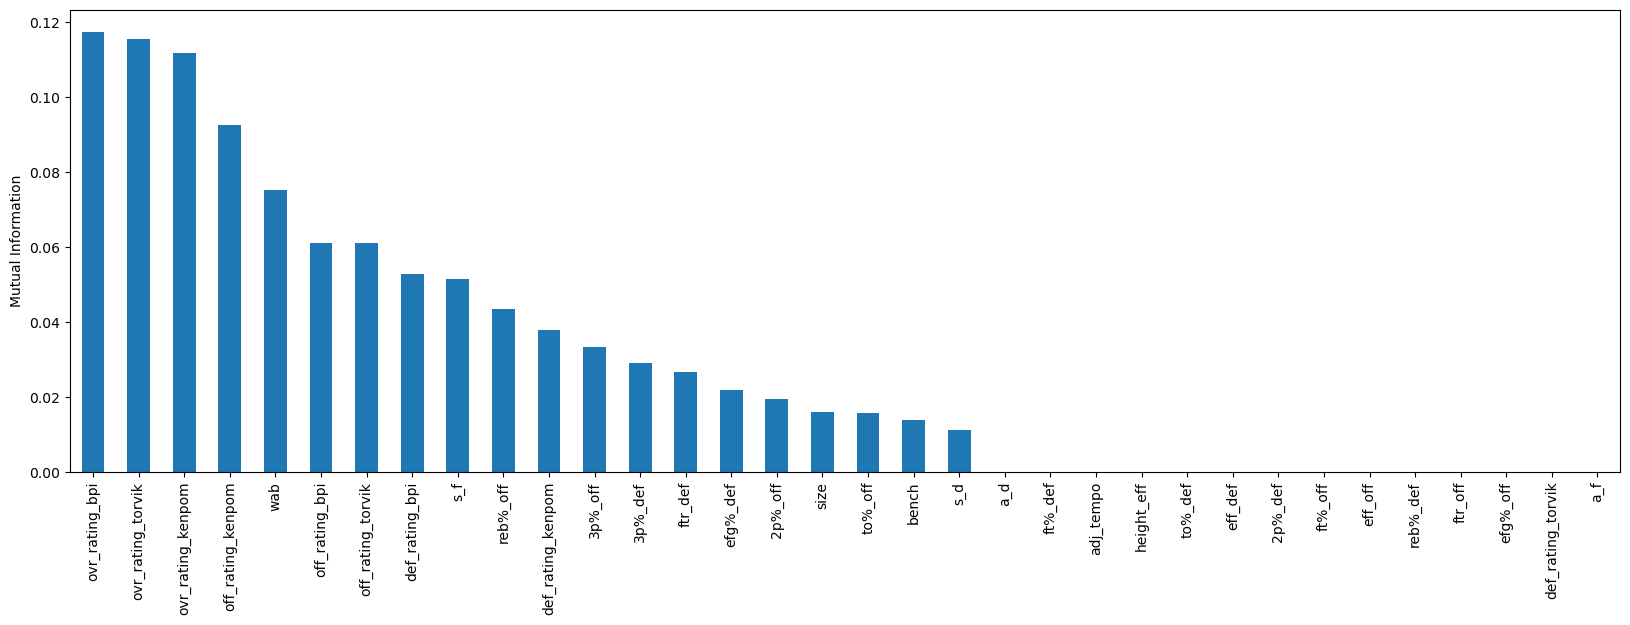

In [338]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [339]:
mi

ovr_rating_bpi      0.1175
ovr_rating_kenpom   0.1117
ovr_rating_torvik   0.1155
wab                 0.0753
off_rating_bpi      0.0610
off_rating_kenpom   0.0926
off_rating_torvik   0.0610
def_rating_bpi      0.0527
def_rating_kenpom   0.0379
def_rating_torvik   0.0000
efg%_off            0.0000
ftr_off             0.0000
reb%_off            0.0434
to%_off             0.0157
efg%_def            0.0219
ftr_def             0.0266
reb%_def            0.0000
to%_def             0.0000
2p%_off             0.0194
3p%_off             0.0333
eff_off             0.0000
ft%_off             0.0000
2p%_def             0.0000
3p%_def             0.0291
eff_def             0.0000
ft%_def             0.0000
height_eff          0.0000
size                0.0160
bench               0.0139
adj_tempo           0.0000
s_d                 0.0110
s_f                 0.0516
a_d                 0.0000
a_f                 0.0000
dtype: float64

In [340]:
sel_ = SelectKBest(f_classif, k=15).fit(X_train, y_train)
X_train.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik',
       'def_rating_bpi', 'def_rating_kenpom', 'def_rating_torvik', 'reb%_off',
       'ftr_def', 'size', 's_f', 'a_f'],
      dtype='object')

# IV. ANOVA

In [341]:
X_num = X_train[[
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo']]

X_cat = X_train[[
    's_d',
    's_f',
    'a_d',
    'a_f']]

<Axes: >

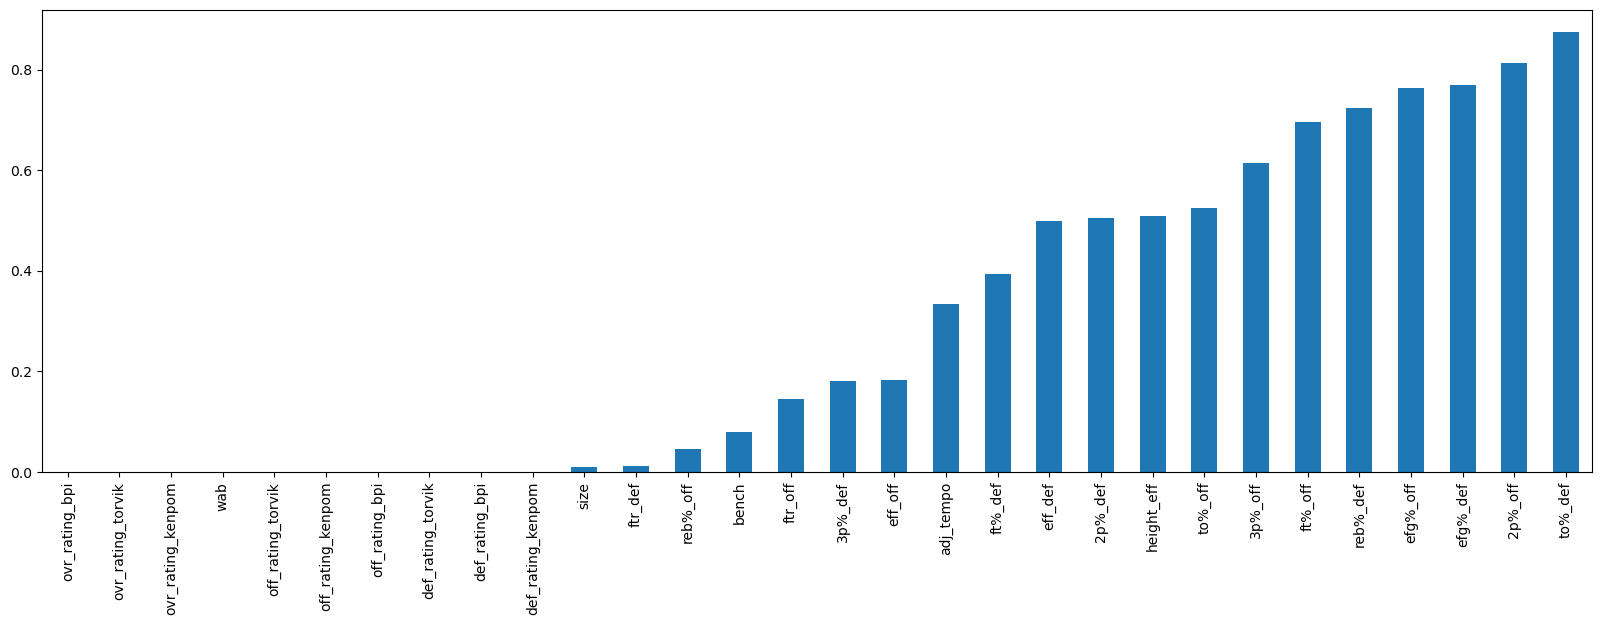

In [342]:
univariate = f_classif(X_num, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_num.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6))

In [343]:
univariate

ovr_rating_bpi      0.0000
ovr_rating_kenpom   0.0000
ovr_rating_torvik   0.0000
wab                 0.0000
off_rating_bpi      0.0000
off_rating_kenpom   0.0000
off_rating_torvik   0.0000
def_rating_bpi      0.0000
def_rating_kenpom   0.0000
def_rating_torvik   0.0000
efg%_off            0.7640
ftr_off             0.1447
reb%_off            0.0458
to%_off             0.5238
efg%_def            0.7685
ftr_def             0.0116
reb%_def            0.7234
to%_def             0.8754
2p%_off             0.8126
3p%_off             0.6134
eff_off             0.1816
ft%_off             0.6953
2p%_def             0.5049
3p%_def             0.1812
eff_def             0.4985
ft%_def             0.3934
height_eff          0.5092
size                0.0095
bench               0.0788
adj_tempo           0.3326
dtype: float64

In [344]:
sel_ = SelectKBest(f_classif, k=15).fit(X_num, y_train)
X_num.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik',
       'def_rating_bpi', 'def_rating_kenpom', 'def_rating_torvik', 'ftr_off',
       'reb%_off', 'ftr_def', 'size', 'bench'],
      dtype='object')

# V. Chi Squared

In [345]:
chi_ls = []

for feature in X_cat.columns:
    c = pd.crosstab(y_train, X_cat[feature])
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

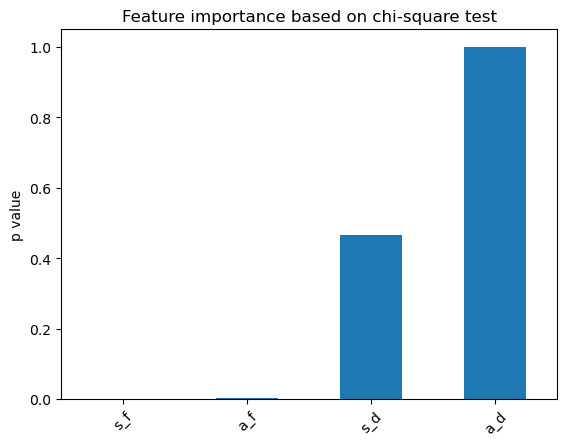

In [346]:
pd.Series(chi_ls, index=X_cat.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [347]:
chi_ls

[0.46688089562319945, 5.672667799968826e-06, 1.0, 0.0031291395897116007]

# VI. Lasso Regression

In [348]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [349]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [350]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 34
selected features: 21
features with coefficients shrank to zero: 13


In [351]:
selected_feat

Index(['ovr_rating_bpi', 'off_rating_torvik', 'def_rating_bpi',
       'def_rating_kenpom', 'ftr_off', 'reb%_off', 'ftr_def', 'reb%_def',
       '2p%_off', '3p%_off', 'ft%_off', '2p%_def', 'eff_def', 'ft%_def',
       'height_eff', 'size', 'bench', 'adj_tempo', 's_d', 's_f', 'a_f'],
      dtype='object')

# VII. Backward Selection

In [352]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [353]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [354]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['ovr_rating_bpi', 'off_rating_torvik', 'ftr_off', 'reb%_off',
       'to%_off', 'reb%_def', '3p%_off', 'eff_off', 'ft%_def', 'a_f'],
      dtype=object)

In [355]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.893470166197439
Test set
Random Forests roc-auc: 0.7593714927048261


In [356]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8965125783307601
Test set
Random Forests roc-auc: 0.7591470258136925


# VIII. Forward Selection

In [357]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [358]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['ovr_rating_bpi', 'off_rating_torvik', 'ftr_off', 'reb%_off',
       'to%_off', 'reb%_def', '3p%_off', 'eff_off', 'ft%_def', 'a_f'],
      dtype=object)

In [359]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.893470166197439
Test set
Random Forests roc-auc: 0.7593714927048261


# IX. ROC-AUC

In [360]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.6031425364758698,
 0.598989898989899,
 0.5111111111111111,
 0.5121212121212121,
 0.6789001122334455,
 0.5444444444444444,
 0.5505050505050505,
 0.5588103254769922,
 0.48787878787878786,
 0.5353535353535355,
 0.6163860830527498,
 0.46397306397306404,
 0.48653198653198654,
 0.5032547699214366,
 0.36745230078563407,
 0.5142536475869809,
 0.4739618406285073,
 0.5078563411896745,
 0.46700336700336703,
 0.5327721661054995,
 0.4888888888888888,
 0.5167227833894501,
 0.45185185185185184,
 0.5297418630751964,
 0.5191919191919192,
 0.46857463524130194,
 0.5305274971941638,
 0.519304152637486,
 0.5109988776655443,
 0.39494949494949494,
 0.504040404040404,
 0.6363636363636364,
 0.5252525252525253,
 0.5343434343434343]

Text(0, 0.5, 'roc-auc')

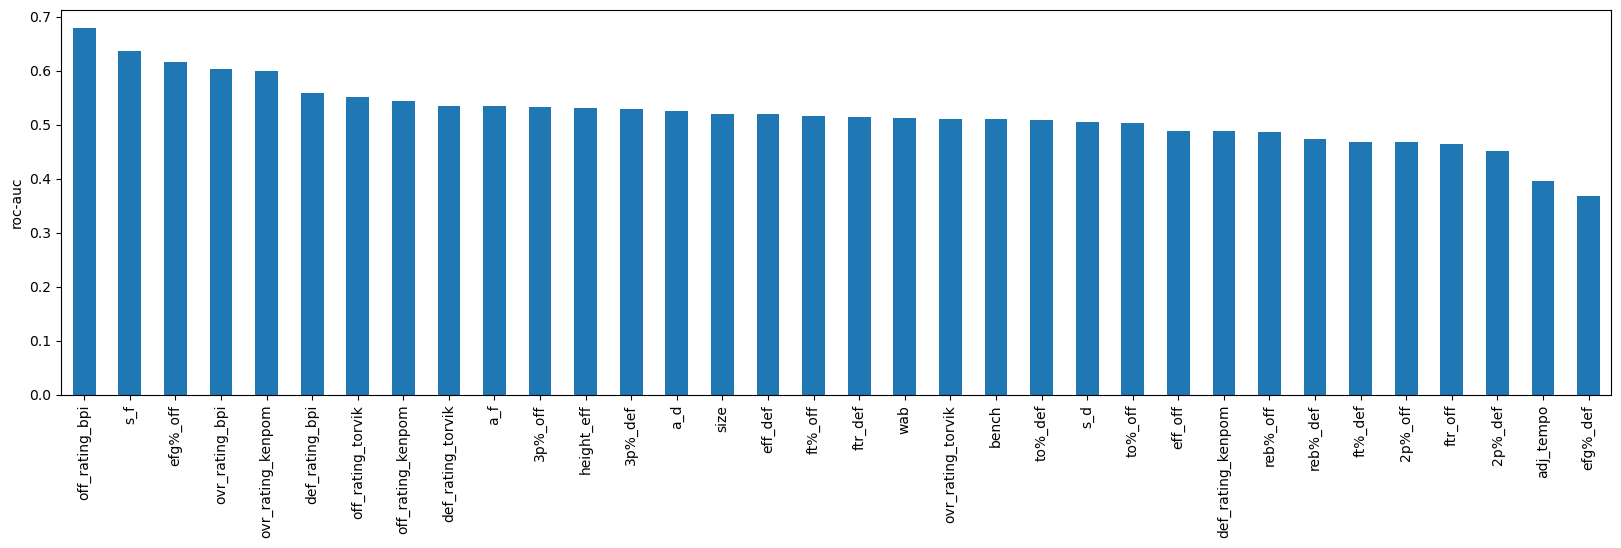

In [361]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [362]:
len(roc_values[roc_values > 0.5])

24

In [363]:
len(roc_values[roc_values > 0.6])

4

# X. Feature Selection

In [364]:
model_df = df[[
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'reb%_off',
 'ftr_off',
 'to%_off',
 'reb%_def',
 '3p%_off',
 'eff_off',
 'ft%_def',
 'eff_def',
 's_f',
 'a_f'
]]
model_df.to_csv('model_features_round1_classic_historical.csv')